#### The below is my walkthrough of the pymc3 tutorial. It is all of the problems they go through, with a few extra notes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy import optimize
%matplotlib inline

In [2]:
# random number generator initialization
np.random.seed(123)

# intercept, sd of error distribution
alpha,sigma = 1,1

# true value of coefficients
beta = [1,2.5]

size = 100

# generating predictor variables of different scales (therefore, predictor variables can have different variances)
X1 = np.random.randn(size)
X2 = np.random.randn(size)*0.2

# observed data
Y = alpha + beta[0]*X1 + beta[1]*X2 +np.random.randn(size)*sigma

Text(0.5,0,'X2')

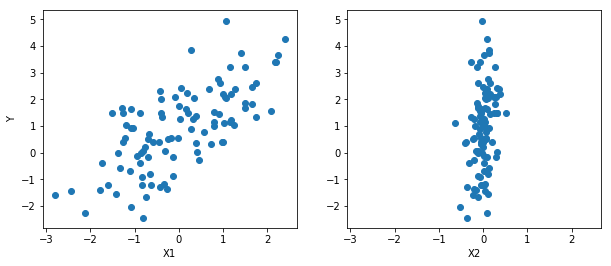

In [3]:
fig, axes = plt.subplots(1,2,sharex=True,figsize=(10,4))
axes[0].scatter(X1,Y)
axes[1].scatter(X2,Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2')

Setting up our basic model. Here, we need to create priors for our unknown model parameters and a likelihood (how we expect our data to act, given the model parameters). For a basic regression, this is a Normal distribution (since the errors are assumed to be normally distributed) 

In [4]:
basic_model = pm.Model()

with basic_model:
    
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0,sd=10)
    beta = pm.Normal('beta',mu=0,sd=10,shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # Likelihood of observations (observations given parameters)
    Y_obs = pm.Normal('Y_obs',mu=mu,sd=sigma,observed=Y)

We can easily do a maximum a posteriori estimate for point estimations - however, these can be biased if posterior mode is not representative of the posterior. Additionally, MAP estimates can fail for multimodal posteriors and for high-dimensional posteriors (high density with low total probability)

In [5]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 4134.25it/s]  


{'alpha': array(0.9066009314912588),
 'beta': array([ 0.94848596,  2.60711845]),
 'sigma': array(0.9629885768973849),
 'sigma_log__': array(-0.037713729250850495)}

We can change optimization routine (default is BFGS)

In [8]:
map_estimate = pm.find_MAP(model=basic_model,method='Powell')
map_estimate

  0%|          | 0/5000 [00:00<?, ?it/s]/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
logp = -149.47, ||grad|| = 13.248: 100%|██████████| 177/177 [00:00<00:00, 3579.31it/s] 


{'alpha': array(0.9090796395146041),
 'beta': array([ 0.9514399 ,  2.61452795]),
 'sigma': array(0.9656806239373911),
 'sigma_log__': array(-0.0349221164775208)}

We can also draw MCMC samples easily

In [6]:
with basic_model:
    # this draws 500 posterior samples
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 1000/1000 [00:00<00:00, 1344.51it/s]


In [7]:
trace['alpha'][-5:]

array([ 0.88393745,  0.88393745,  0.911917  ,  0.92470843,  0.90057717])

In [8]:
with basic_model:
    # find a starting point
    start = pm.find_MAP(method='Powell')
    # sampling algorithm
    step = pm.Slice()
    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, start=start)

  0%|          | 0/5000 [00:00<?, ?it/s]/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
logp = -149.47, ||grad|| = 13.248: 100%|██████████| 177/177 [00:00<00:00, 3772.85it/s] 
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma_log__]
>Slice: [beta]
>Slice: [alpha]
100%|██████████| 5500/5500 [00:05<00:00, 1036.65it/s]


We can then look at the trace of these samples

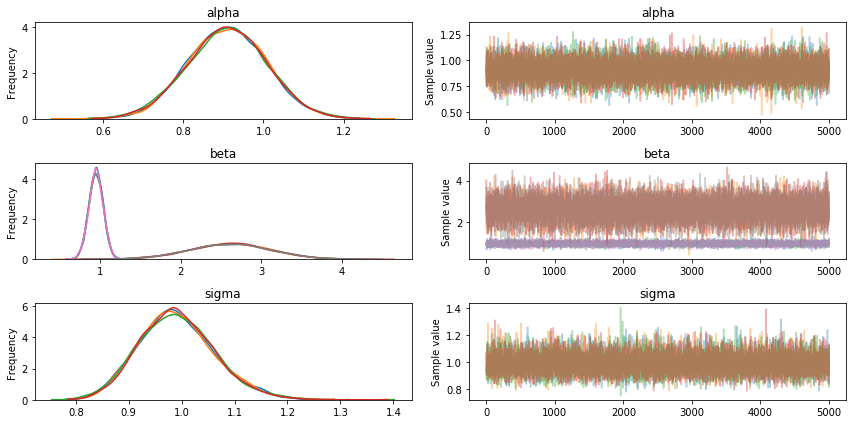

In [9]:
_ = pm.traceplot(trace)

In [10]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.907832,0.099196,0.000669,0.713416,1.099686,19664.0,0.999914
beta__0,0.948995,0.089483,0.000570,0.772646,1.123687,20000.0,0.999925
beta__1,2.604886,0.512019,0.003777,1.584799,3.597961,19790.0,1.000037
sigma,0.990786,0.071210,0.000465,0.855026,1.132712,17930.0,0.999966


#### Example Problem (stochastic volatility)

Here, the problem is the high-dimensionality of the space (yielding high correlation among variables), as well as a non-normal likelihood. The NUTS sampler does quite well with high dimension of parameters.

In [26]:
from pandas_datareader import data

In [27]:
import pandas as pd

returns = data.get_data_yahoo('SPY', start = '2008-5-1', end='2009-12-1')['Close'].pct_change()

len(returns)

ImmediateDeprecationError: 
Yahoo Actions has been immediately deprecated due to large breaks in the API without the
introduction of a stable replacement. Pull Requests to re-enable these data
connectors are welcome.

See https://github.com/pydata/pandas-datareader/issues


#### Coal mining

Here, we'll see how to handle missing data, use multiple samplers and sample from discrete random variables.

In [14]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)

Text(0.5,0,'Year')

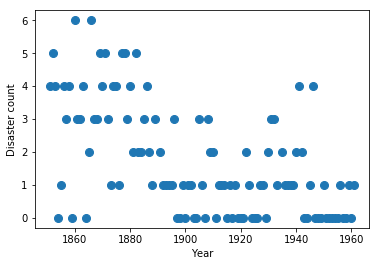

In [15]:
year = np.arange(1851, 1962)

plt.plot(year,disaster_data, 'o', markersize=8)
plt.ylabel("Disaster count")
plt.xlabel("Year")

We want to find when the change in the mean of the Poisson process occurred

In [16]:
with pm.Model() as disaster_model:
    
    switchpoint = pm.DiscreteUniform('switchpoint',lower=year.min(),upper=year.max(),testval=1900)
    
    # Priors for pre- and post-switch rates
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)
    
    # Rate switches between early and late based on switchpoint
    rate = pm.math.switch(switchpoint >= year, early_rate, late_rate)
    
    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

disasters.missing_values is created to model the missing values - so we'll need to sample this random variable as well (which is discrete). Missing_values, as well as the switchpoint, are discrete, which precludes using a gradient-based sampler - so we'll have to use Metropolis. Fortunately, we don't even have to specify this:

In [17]:
with disaster_model:
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate_log__, early_rate_log__]
100%|█████████▉| 10490/10500 [00:07<00:00, 1390.15it/s]/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 10500/10500 [00:07<00:00, 1389.33it/s]
/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the w

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fedc5215748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fedc50d56d8>]], dtype=object)

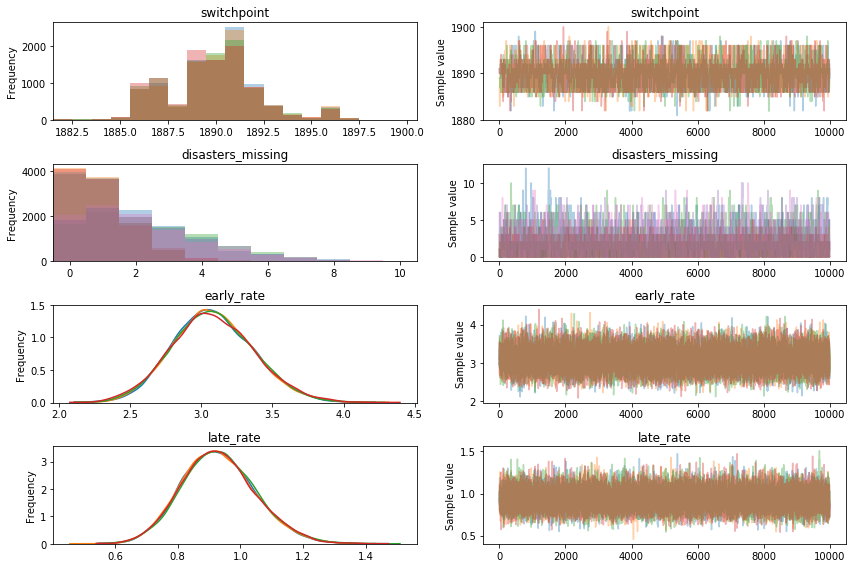

In [18]:
pm.traceplot(trace)

### GLM (R-like syntax)

In [19]:
import pandas

df = pandas.DataFrame({'x1': X1, 'x2': X2, 'y': Y})

In [20]:
from pymc3.glm import GLM

with pm.Model() as model_glm:
    # much more concise way of handing a model
    GLM.from_formula('y~x1+x2',df)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_log__, x2, x1, Intercept]
100%|██████████| 1000/1000 [00:00<00:00, 1358.75it/s]


Here the error distribution is assumed to be normal (this can be changed with the family argument)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fedd403da90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fedc40d2e48>]], dtype=object)

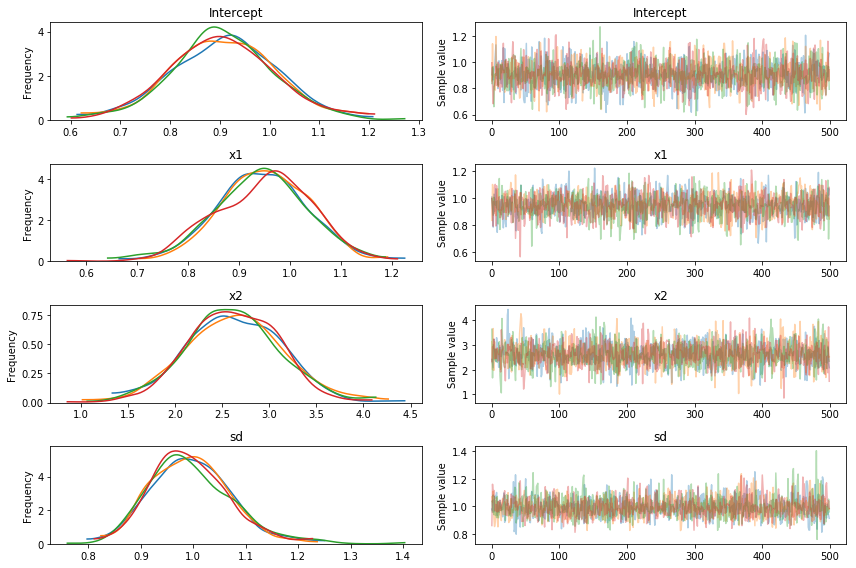

In [21]:
pm.traceplot(trace)